# 4Day subsampling on the OceanColor Dataset

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

## Load data from disk

We already downloaded a subsetted MODIS-Aqua chlorophyll-a dataset for the Arabian Sea.

We can read all the netcdf files into one xarray Dataset using the `open_mfsdataset` function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [9]:
ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_D.nc')
both_datasets = [ds_8day, ds_daily]

How much data is contained here? Let's get the answer in MB.

In [10]:
print([(ds.nbytes / 1e6) for ds in both_datasets])

[534.295504, 4241.4716]


The 8-day dataset is ~534 MB while the daily dataset is 4.2 GB. These both easily fit in RAM. So let's load them all into memory

In [11]:
[ds.load() for ds in both_datasets]

[<xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 667)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
   * time           (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
 Data variables:
     chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
     palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...,
 <xarray.Dataset>
 Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 5295)
 Coordinates:
   * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
   * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
   * rgb            (rgb) int64 0 1 2
   * eightbitcolor  (eightbitcolor) int64 0 

## Fix bad data

In preparing this demo, I noticed that small number of maps had bad data--specifically, they contained large negative values of chlorophyll concentration. Looking closer, I realized that the land/cloud mask had been inverted. So I wrote a function to invert it back and correct the data.

In [12]:
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are chlorophyl values less than zero
    bad_data = ds.chlor_a.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.chlor_a[n].values 
        ds.chlor_a.values[n] = np.ma.masked_less(data, 0).filled(np.nan)

In [13]:
[fix_bad_data(ds) for ds in both_datasets]

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in less
  if not reflexive


[None, None]

In [14]:
ds_8day.chlor_a>0

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


<xarray.DataArray 'chlor_a' (time: 667, lat: 276, lon: 360)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ..., 
        [False, False, False, ..., Fal

## Count the number of ocean data points

First we have to figure out the land mask. Unfortunately it doesn't come with the dataset. But we can infer it by counting all the points that have at least one non-nan chlorophyll value.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


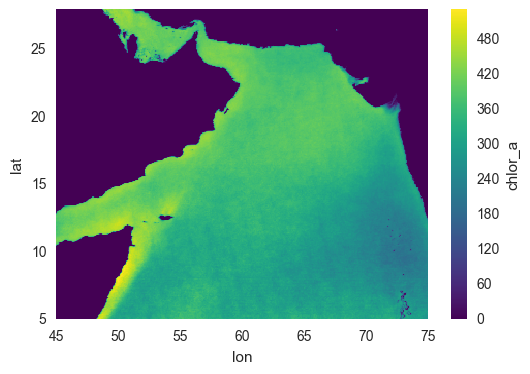

In [15]:
(ds_8day.chlor_a>0).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in greater
  if not reflexive


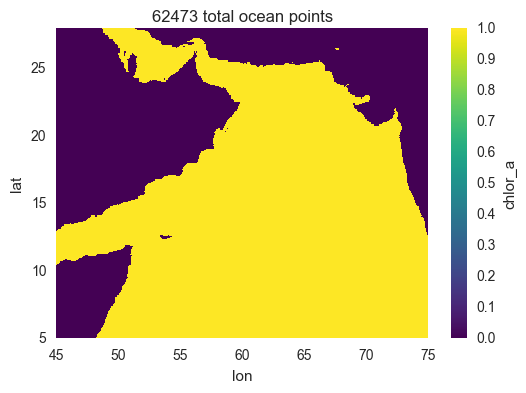

In [16]:
#  find a mask for the land
ocean_mask = (ds_8day.chlor_a>0).sum(dim='time')>0
#ocean_mask = (ds_daily.chlor_a>0).sum(dim='time')>0
num_ocean_points = ocean_mask.sum().values  # compute the total nonzeros regions(data point)
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

In [17]:
#ds_8day

In [18]:
#ds_daily

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


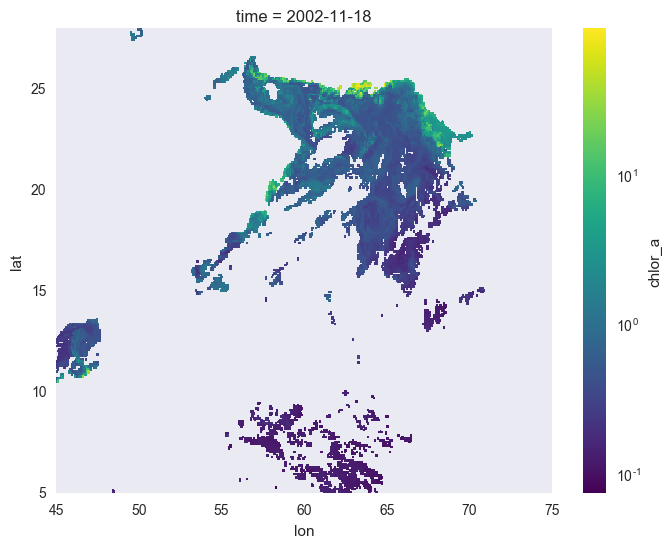

In [19]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())
#ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [20]:
#list(ds_daily.groupby('time')) # take a look at what's inside

Now we count up the number of valid points in each snapshot and divide by the total number of ocean points.

In [21]:
'''
<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 144, lon: 276, rgb: 3, time: 4748)
'''
ds_daily.groupby('time').count() # information from original data

<xarray.Dataset>
Dimensions:  (time: 5295)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    chlor_a  (time) int64 658 1170 1532 2798 2632 1100 1321 636 2711 1163 ...
    palette  (time) int64 768 768 768 768 768 768 768 768 768 768 768 768 ...

In [22]:
ds_daily.chlor_a.groupby('time').count()/float(num_ocean_points)

<xarray.DataArray 'chlor_a' (time: 5295)>
array([ 0.01053255,  0.01872809,  0.02452259, ...,  0.        ,
        0.        ,  0.        ])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

In [23]:
count_8day,count_daily = [ds.chlor_a.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

In [24]:
#count_8day = ds_8day.chl_ocx.groupby('time').count()/float(num_ocean_points)
#coundt_daily = ds_daily.chl_ocx.groupby('time').count()/float(num_ocean_points)

#count_8day, coundt_daily = [ds.chl_ocx.groupby('time').count()/float(num_ocean_points)
#                            for ds in ds_8day, ds_daily] # not work in python 3


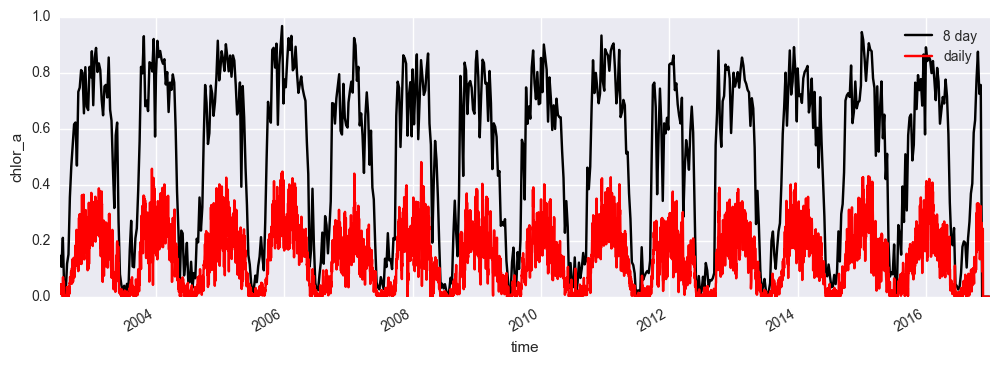

In [25]:
plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])

## Seasonal Climatology

In [26]:
count_8day_clim, coundt_daily_clim = [count.groupby('time.month').mean()  # monthly data
                                      for count in (count_8day, count_daily)]

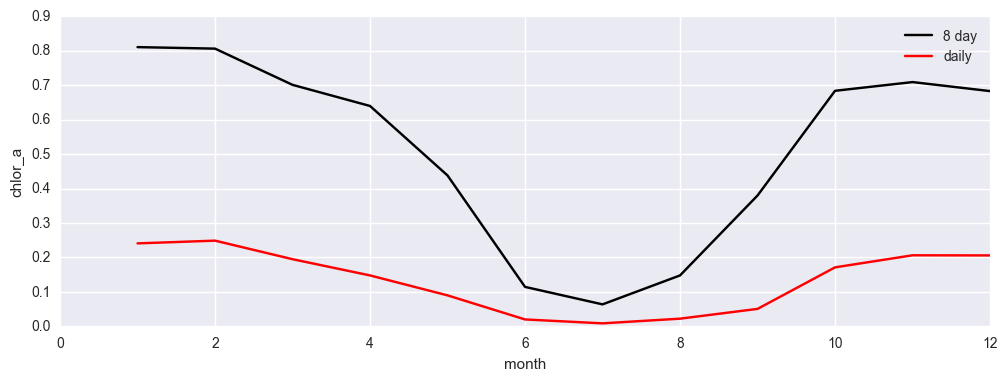

In [27]:
# mean value of the monthly data on the count of nonzeros
plt.figure(figsize=(12,4))
count_8day_clim.plot(color='k')
coundt_daily_clim.plot(color='r')
plt.legend(['8 day', 'daily'])

From the above figure, we see that data coverage is highest in the winter (especially Feburary) and lowest in summer.

## Maps of individual days

Let's grab some data from Febrauary and plot it.

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


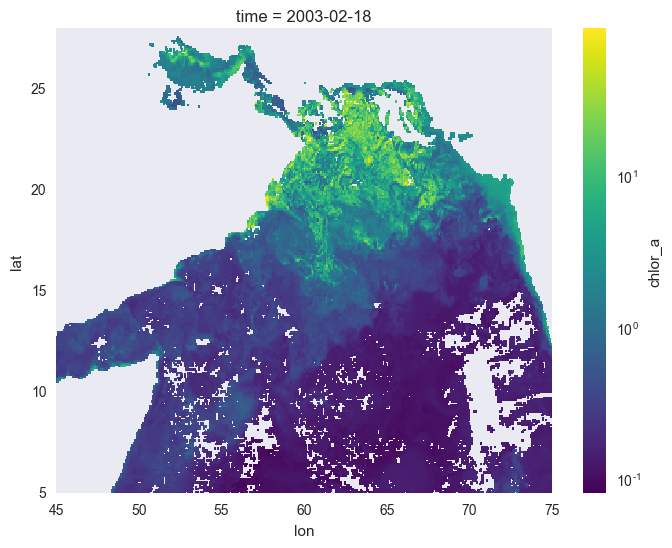

In [28]:
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


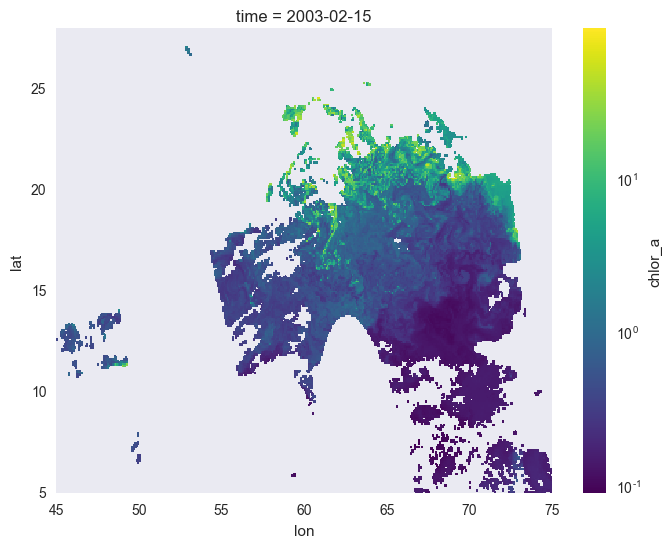

In [29]:
plt.figure(figsize=(8,6))
ds_daily.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [30]:
ds_daily.chlor_a[0].sel_points(lon=[65, 70], lat=[16, 18], method='nearest')   # the time is selected!
#ds_daily.chl_ocx[0].sel_points(time= times, lon=lons, lat=times, method='nearest')

<xarray.DataArray 'chlor_a' (points: 2)>
array([ nan,  nan])
Coordinates:
    time     datetime64[ns] 2002-07-04
    lat      (points) float64 16.04 18.04
    lon      (points) float64 65.04 70.04
  * points   (points) int64 0 1

In [31]:
#ds_daily.chlor_a.sel_points?

In [32]:
ds_4day = ds_daily.resample('4D', dim='time')
ds_4day

<xarray.Dataset>
Dimensions:        (eightbitcolor: 256, lat: 276, lon: 360, rgb: 3, time: 1324)
Coordinates:
  * lat            (lat) float64 27.96 27.87 27.79 27.71 27.62 27.54 27.46 ...
  * lon            (lon) float64 45.04 45.13 45.21 45.29 45.38 45.46 45.54 ...
  * rgb            (rgb) int64 0 1 2
  * eightbitcolor  (eightbitcolor) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * time           (time) datetime64[ns] 2002-07-04 2002-07-08 2002-07-12 ...
Data variables:
    chlor_a        (time, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    palette        (time, rgb, eightbitcolor) float64 -109.0 0.0 108.0 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


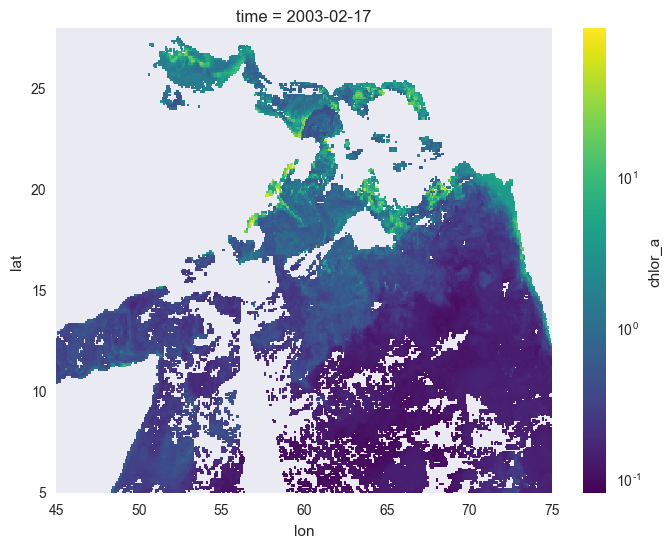

In [33]:
plt.figure(figsize=(8,6))
ds_4day.chlor_a.sel(time=target_date, method='nearest').plot(norm=LogNorm())

In [66]:
# check the range for the longitude
print(ds_4day.lon.min(),'\n' ,ds_4day.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.04166793823242) 
 <xarray.DataArray 'lat' ()>
array(5.041661739349365)


# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [67]:
# in the following we deal with the data from the gdp float
from buyodata import buoydata
import os

In [68]:
# a list of files
fnamesAll = ['./gdp_float/buoydata_1_5000.dat','./gdp_float/buoydata_5001_10000.dat','./gdp_float/buoydata_10001_15000.dat','./gdp_float/buoydata_15001_jun16.dat']

In [69]:
# read them and cancatenate them into one DataFrame
dfAll = pd.concat([buoydata.read_buoy_data(f) for f in fnamesAll])  # around 4~5 minutes

#mask = df.time>='2002-07-04' # we only have data after this data for chlor_a
dfvvAll = dfAll[dfAll.time>='2002-07-04']

sum(dfvvAll.time<'2002-07-04') # recheck whether the time is 

0

In [70]:
# process the data so that the longitude are all >0
print('before processing, the minimum longitude is%f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(), dfvvAll.lon.max()))
mask = dfvvAll.lon<0
dfvvAll.lon[mask] = dfvvAll.loc[mask].lon + 360
print('after processing, the minimum longitude is %f4.3 and maximum is %f4.3' % (dfvvAll.lon.min(),dfvvAll.lon.max()) )

dfvvAll.describe()

before processing, the minimum longitude is0.0000004.3 and maximum is 360.0000004.3


/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/core/generic.py:4695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

after processing, the minimum longitude is 0.0000004.3 and maximum is 360.0000004.3


,id,lat,lon,temp,ve,vn,spd,var_lat,var_lon,var_tmp
count,2.147732e+07,2.131997e+07,2.131997e+07,1.986179e+07,2.129142e+07,2.129142e+07,2.129142e+07,2.147732e+07,2.147732e+07,2.147732e+07
mean,1.765662e+06,-2.263128e+00,2.124412e+02,1.986121e+01,2.454172e-01,4.708192e-01,2.613427e+01,7.326258e+00,7.326555e+00,7.522298e+01
std,9.452835e+06,3.401115e+01,9.746941e+01,8.339498e+00,2.525050e+01,2.052160e+01,1.939087e+01,8.527853e+01,8.527851e+01,2.637454e+02
min,2.578000e+03,-7.764700e+01,0.000000e+00,-1.685000e+01,-2.916220e+02,-2.601400e+02,0.000000e+00,5.268300e-07,-3.941600e-02,1.001300e-03
25%,4.897500e+04,-3.186000e+01,1.490720e+02,1.437300e+01,-1.411400e+01,-1.044700e+01,1.290300e+01,4.366500e-06,7.512600e-06,1.435700e-03
50%,7.141300e+04,-4.920000e+00,2.153940e+02,2.214400e+01,-5.560000e-01,1.970000e-01,2.176700e+01,8.833600e-06,1.495800e-05,1.691700e-03
75%,1.094330e+05,2.756000e+01,3.064370e+02,2.688900e+01,1.356100e+01,1.109300e+01,3.405900e+01,1.833300e-05,3.627900e-05,2.294200e-03
max,6.399288e+07,8.989900e+01,3.600000e+02,4.595000e+01,4.417070e+02,2.783220e+02,4.421750e+02,1.000000e+03,1.000000e+03,1.000000e+03


In [71]:
# Select only the arabian sea region
arabian_sea = (dfvvAll.lon > 45) & (dfvvAll.lon< 75) & (dfvvAll.lat> 5) & (dfvvAll.lat <28)
# arabian_sea = {'lon': slice(45,75), 'lat': slice(5,28)} # later use this longitude and latitude
floatsAll = dfvvAll.loc[arabian_sea]   # directly use mask
print('dfvvAll.shape is %s, floatsAll.shape is %s' % (dfvvAll.shape, floatsAll.shape) )

dfvvAll.shape is (21477317, 11), floatsAll.shape is (111894, 11)


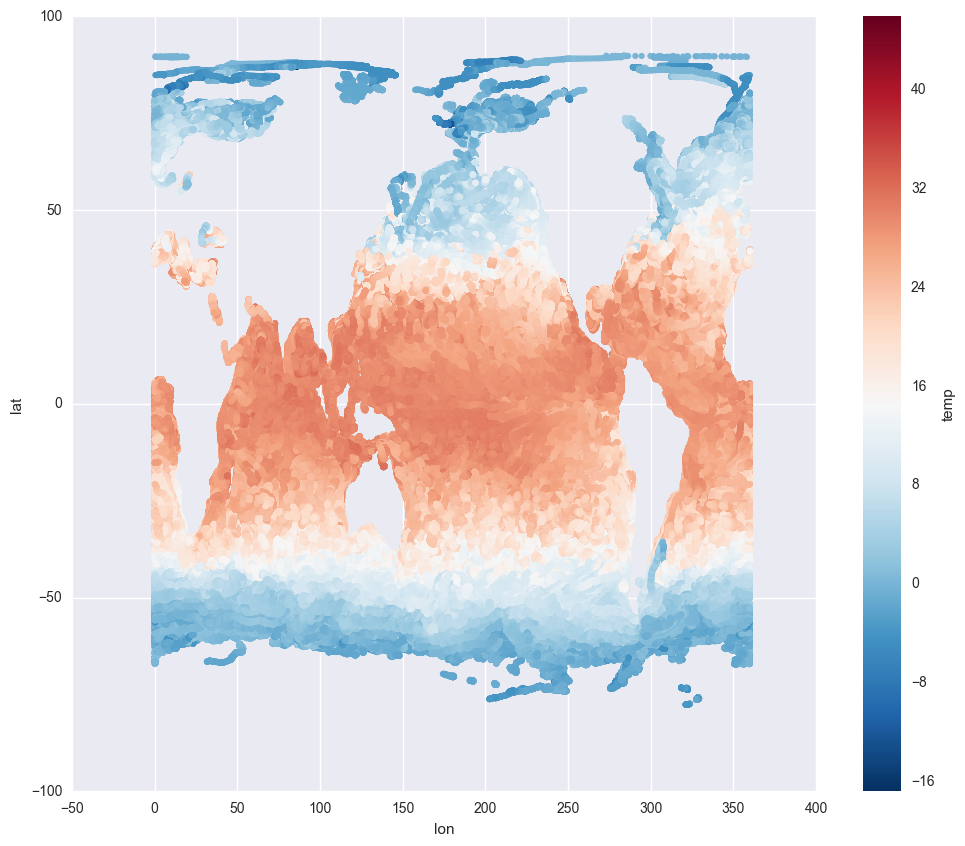

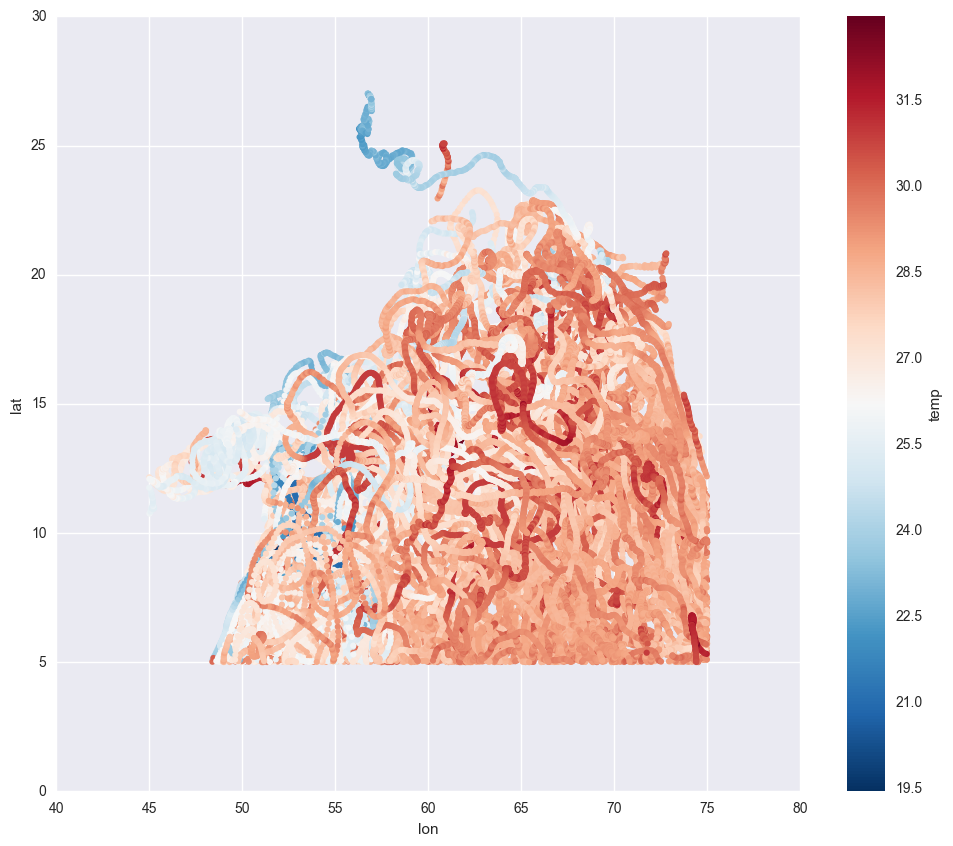

In [72]:
# avoid run this line repeatedly
# visualize the float around global region
fig, ax  = plt.subplots(figsize=(12,10))
dfvvAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsAll.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [73]:
# pands dataframe cannot do the resamplingn properly
# cause we are really indexing on ['time','id'], pandas.dataframe.resample cannot do this
# TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'MultiIndex'
print()

In [74]:
# dump the surface floater data from pandas.dataframe to xarray.dataset
floatsDSAll = xr.Dataset.from_dataframe(floatsAll.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
floatsDSAll

<xarray.Dataset>
Dimensions:  (id: 259, time: 17499)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-04T06:00:00 ...
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
Data variables:
    lat      (time, id) float64 nan 16.3 14.03 16.4 14.04 nan 20.11 nan ...
    lon      (time, id) float64 nan 66.23 69.48 64.58 69.51 nan 68.55 nan ...
    temp     (time, id) float64 nan nan nan 28.0 28.53 nan 28.93 nan 27.81 ...
    ve       (time, id) float64 nan 8.68 5.978 6.286 4.844 nan 32.9 nan ...
    vn       (time, id) float64 nan -13.18 -18.05 -7.791 -17.47 nan 15.81 ...
    spd      (time, id) float64 nan 15.78 19.02 10.01 18.13 nan 36.51 nan ...
    var_lat  (time, id) float64 nan 0.0002661 5.01e-05 5.018e-05 5.024e-05 ...
    var_lon  (time, id) float64 nan 0.0006854 8.851e-05 9.018e-05 8.968e-05 ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003733 0.0667 nan 0.001683 ...

In [75]:
# resample on the xarray.dataset onto two-day frequency
floatsDSAll_4D =floatsDSAll.resample('4D', dim='time')
floatsDSAll_4D

<xarray.Dataset>
Dimensions:  (id: 259, time: 1278)
Coordinates:
  * id       (id) int64 7574 10206 10208 11089 15703 15707 27069 27139 28842 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-08 2002-07-12 ...
Data variables:
    ve       (time, id) float64 nan 9.425 10.36 12.13 9.833 nan 26.62 nan ...
    vn       (time, id) float64 nan -4.747 -17.28 -5.897 -16.89 nan 0.7761 ...
    lat      (time, id) float64 nan 16.2 13.75 16.31 13.77 nan 20.17 nan ...
    spd      (time, id) float64 nan 10.92 20.58 14.22 19.98 nan 28.07 nan ...
    var_tmp  (time, id) float64 nan 1e+03 1e+03 0.003583 0.0803 nan 0.001669 ...
    temp     (time, id) float64 nan nan nan 27.88 28.56 nan 28.95 nan 27.67 ...
    var_lon  (time, id) float64 nan 0.008014 9.423e-05 0.0001387 9.623e-05 ...
    var_lat  (time, id) float64 nan 0.002037 5.228e-05 7.135e-05 5.294e-05 ...
    lon      (time, id) float64 nan 66.41 69.63 64.78 69.66 nan 68.95 nan ...

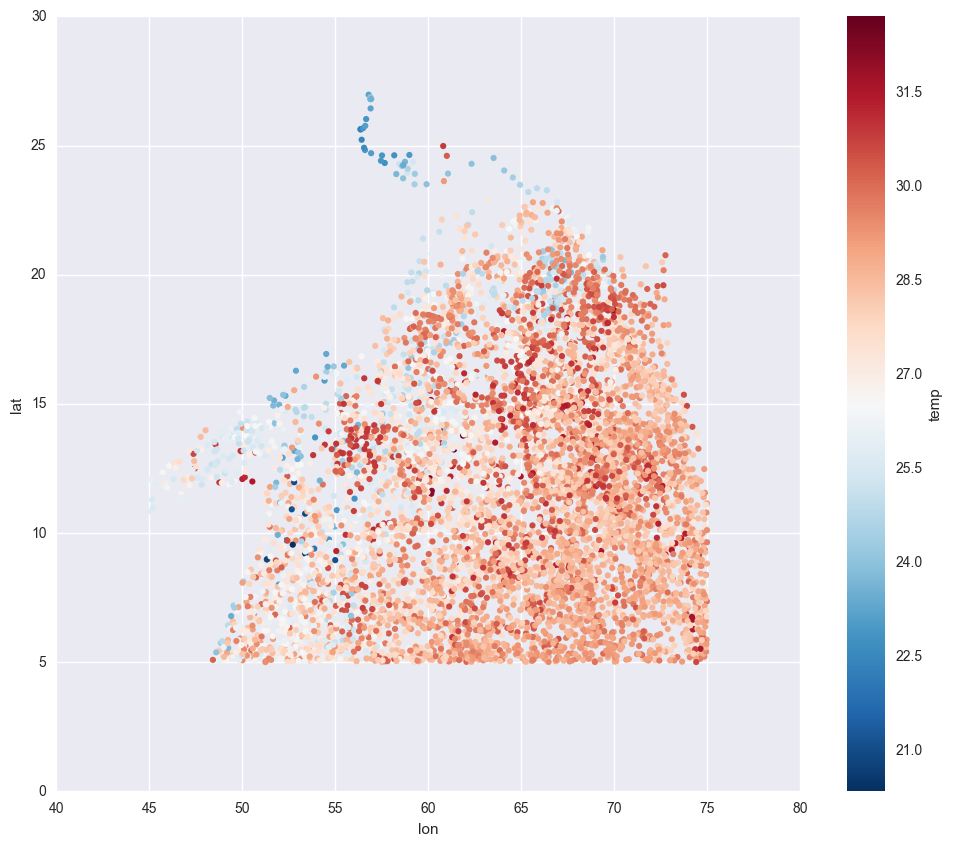

In [76]:
# transfer it back to pandas.dataframe for plotting
floatsDFAll_4D = floatsDSAll_4D.to_dataframe()
floatsDFAll_4D
floatsDFAll_4D = floatsDFAll_4D.reset_index()
floatsDFAll_4D
# visualize the subsamping of floats around arabian region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_4D.plot(kind='scatter', x='lon', y='lat', c='temp', cmap='RdBu_r', edgecolor='none', ax=ax)

In [77]:
# get the value for the chllorophy for each data entry
floatsDFAll_4Dtimeorder = floatsDFAll_4D.sort_values(['time','id'],ascending=True)
floatsDFAll_4Dtimeorder # check whether it is time ordered!!
# should we drop nan to speed up??

,id,time,ve,vn,lat,spd,var_tmp,temp,var_lon,var_lat,lon
0,7574,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,10206,2002-07-04,9.425000,-4.747250,16.196125,10.918125,1000.000000,NaN,0.008014,0.002037,66.409813
2556,10208,2002-07-04,10.355438,-17.277062,13.752000,20.576187,1000.000000,NaN,0.000094,0.000052,69.632875
3834,11089,2002-07-04,12.128187,-5.896938,16.305750,14.222375,0.003583,27.884125,0.000139,0.000071,64.777500
5112,15703,2002-07-04,9.833375,-16.894688,13.766187,19.978313,0.080302,28.558125,0.000096,0.000053,69.657312
6390,15707,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7668,27069,2002-07-04,26.620125,0.776125,20.173938,28.072937,0.001669,28.946250,0.000104,0.000056,68.953562
8946,27139,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10224,28842,2002-07-04,8.325375,-5.037438,18.808937,22.278562,0.003263,27.669500,0.000197,0.000095,60.774188
11502,34159,2002-07-04,26.471125,6.662250,12.600438,27.822062,1000.000000,NaN,0.000101,0.000054,59.108062


In [78]:
floatsDFAll_4Dtimeorder.lon.dropna().shape  # the longitude data has lots of values (7349,)

(7349,)

In [79]:
# a little test for the api in loops for the dataframe   
# check df.itertuples? it is faster and preserves the data format
'''
chl_ocx=[]
for row in floats_timeorder.itertuples():
    #print(row)
    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )
    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation
    chl_ocx.append(tmp)
floats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)
chl_ocx[0].to_series
'''

"\nchl_ocx=[]\nfor row in floats_timeorder.itertuples():\n    #print(row)\n    #print('row.time = %s, row.id=%d, row.lon=%4.3f, row.lat=%4.3f' % (row.time,row.id,row.lon,row.lat)  )\n    tmp=ds_2day.chl_ocx.sel_points(time=[row.time],lon=[row.lon], lat=[row.lat], method='nearest') # interpolation\n    chl_ocx.append(tmp)\nfloats_timeorder['chl_ocx'] = pd.Series(chl_ocx, index=floats_timeorder.index)\nchl_ocx[0].to_series\n"

In [80]:
# this one line avoid the list above
# it took a really long time for 2D interpolation, it takes an hour
tmpAll = ds_4day.chlor_a.sel_points(time=list(floatsDFAll_4Dtimeorder.time),lon=list(floatsDFAll_4Dtimeorder.lon), lat=list(floatsDFAll_4Dtimeorder.lat), method='nearest')
print('the count of nan vaues in tmpAll is',tmpAll.to_series().isnull().sum())

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less_equal
  indexer = np.where(op(left_distances, right_distances) |
/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/pandas/indexes/base.py:2352: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |


the count of nan vaues in tmpAll is 328760


In [81]:
#print(tmpAll.dropna().shape)
tmpAll.to_series().dropna().shape  # (2242,) good values

(2242,)

after editing the dataframe the nan values in 'chlor_a' is 328760


(2242,)

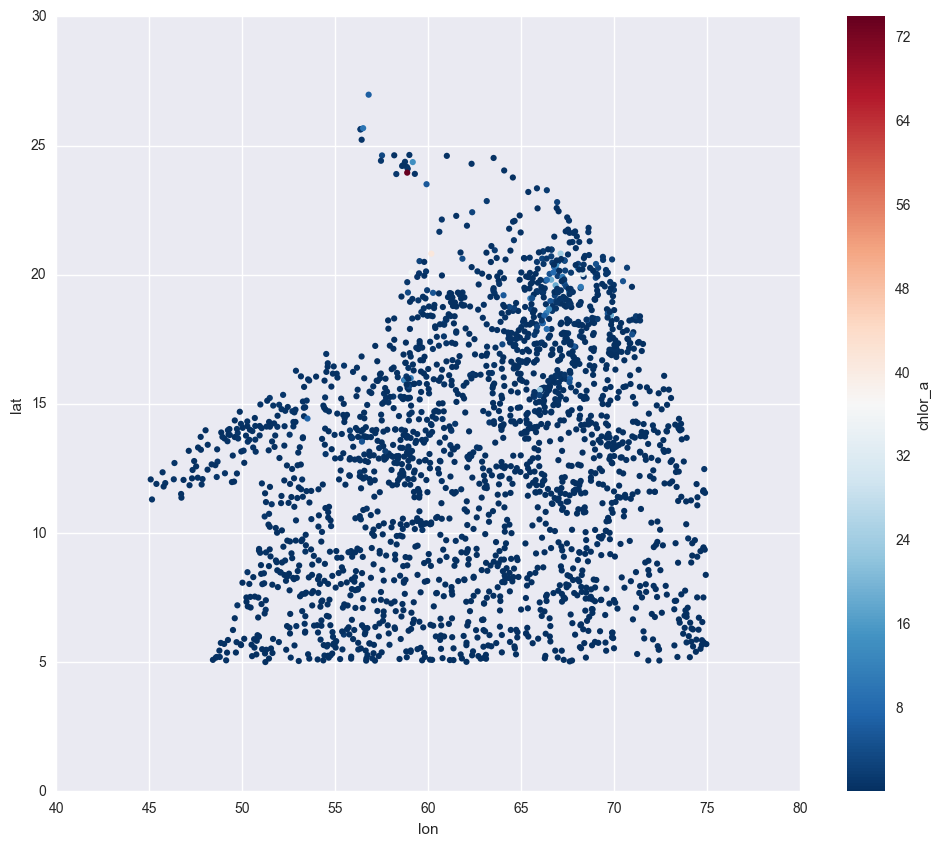

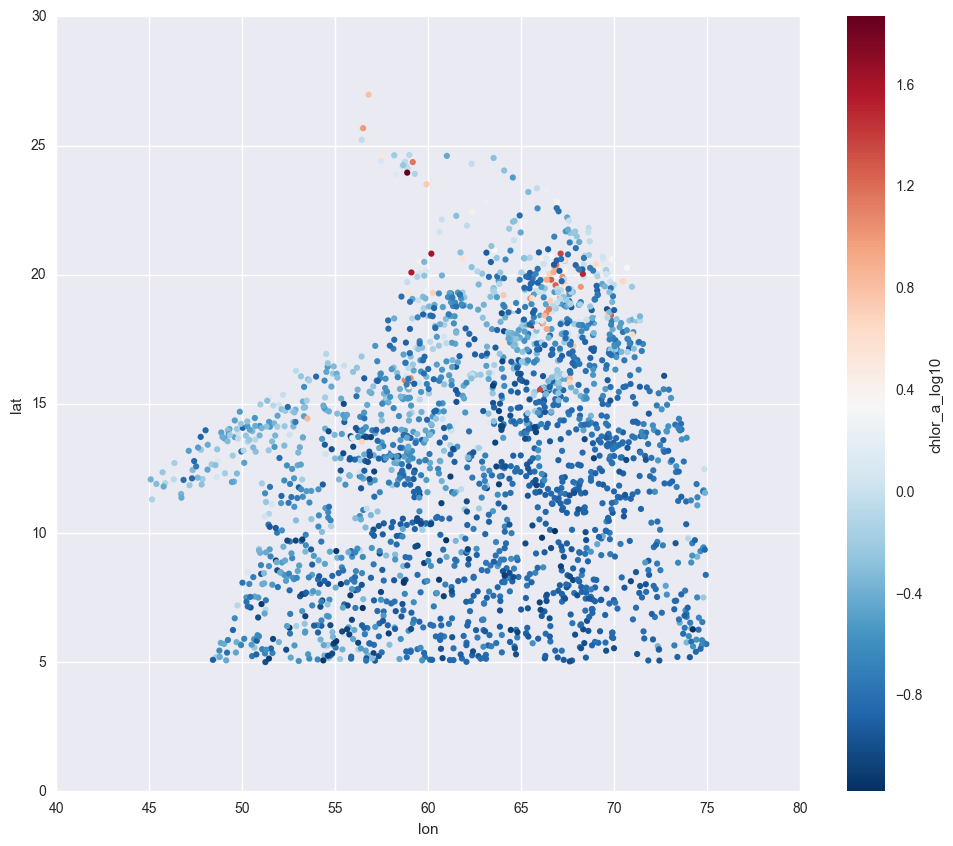

In [83]:
# tmp.to_series() to transfer it from xarray dataset to series
floatsDFAll_4Dtimeorder['chlor_a'] = pd.Series(np.array(tmpAll.to_series()), index=floatsDFAll_4Dtimeorder.index)
print("after editing the dataframe the nan values in 'chlor_a' is", floatsDFAll_4Dtimeorder.chlor_a.isnull().sum() )  # they should be the same values as above

# take a look at the data
floatsDFAll_4Dtimeorder

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_4Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a', cmap='RdBu_r', edgecolor='none', ax=ax)

def scale(x):
    logged = np.log10(x)
    return logged

#print(floatsAll_timeorder['chlor_a'].apply(scale))
floatsDFAll_4Dtimeorder['chlor_a_log10'] = floatsDFAll_4Dtimeorder['chlor_a'].apply(scale)
floatsDFAll_4Dtimeorder
#print("after the transformation the nan values in 'chlor_a_log10' is", floatsAll_timeorder.chlor_a_log10.isnull().sum() )

# visualize the float around the arabian sea region
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAll_4Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chlor_a_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
floatsDFAll_4Dtimeorder.chlor_a.dropna().shape  # (2242,)
#floatsDFAll_4Dtimeorder.chlor_a_log10.dropna().shape  # (2242,)

In [84]:
# take the diff of the chlor_a, and this has to be done in xarray
# transfer the dataframe into xarry dataset again
# take the difference
floatsDFAll_4Dtimeorder

,id,time,ve,vn,lat,spd,var_tmp,temp,var_lon,var_lat,lon,chlor_a,chlor_a_log10
0,7574,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1278,10206,2002-07-04,9.425000,-4.747250,16.196125,10.918125,1000.000000,NaN,0.008014,0.002037,66.409813,NaN,NaN
2556,10208,2002-07-04,10.355438,-17.277062,13.752000,20.576187,1000.000000,NaN,0.000094,0.000052,69.632875,NaN,NaN
3834,11089,2002-07-04,12.128187,-5.896938,16.305750,14.222375,0.003583,27.884125,0.000139,0.000071,64.777500,NaN,NaN
5112,15703,2002-07-04,9.833375,-16.894688,13.766187,19.978313,0.080302,28.558125,0.000096,0.000053,69.657312,NaN,NaN
6390,15707,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7668,27069,2002-07-04,26.620125,0.776125,20.173938,28.072937,0.001669,28.946250,0.000104,0.000056,68.953562,NaN,NaN
8946,27139,2002-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10224,28842,2002-07-04,8.325375,-5.037438,18.808937,22.278562,0.003263,27.669500,0.000197,0.000095,60.774188,NaN,NaN
11502,34159,2002-07-04,26.471125,6.662250,12.600438,27.822062,1000.000000,NaN,0.000101,0.000054,59.108062,NaN,NaN


In [85]:
# unstack() will provide a 2d dataframe
# reset_index() will reset all the index as columns

check the sum of the chlor_a before the merge -102.27282937678196
check the sum of the chlor_a after the merge -102.27282937678196


(493,)

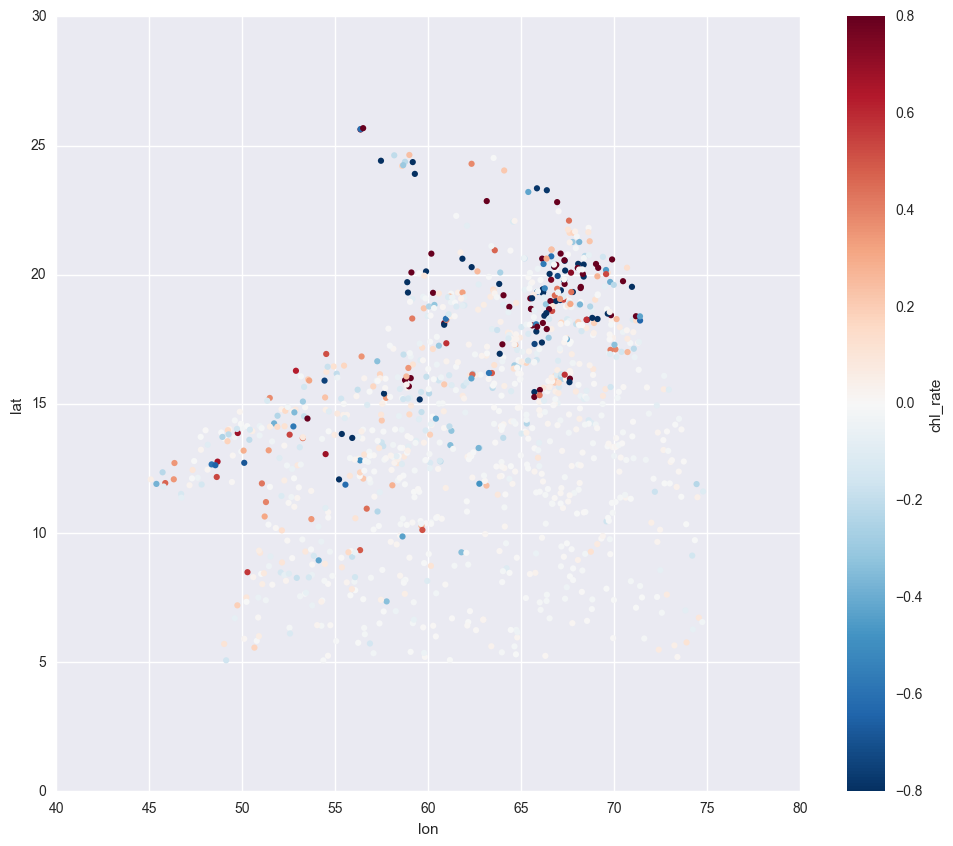

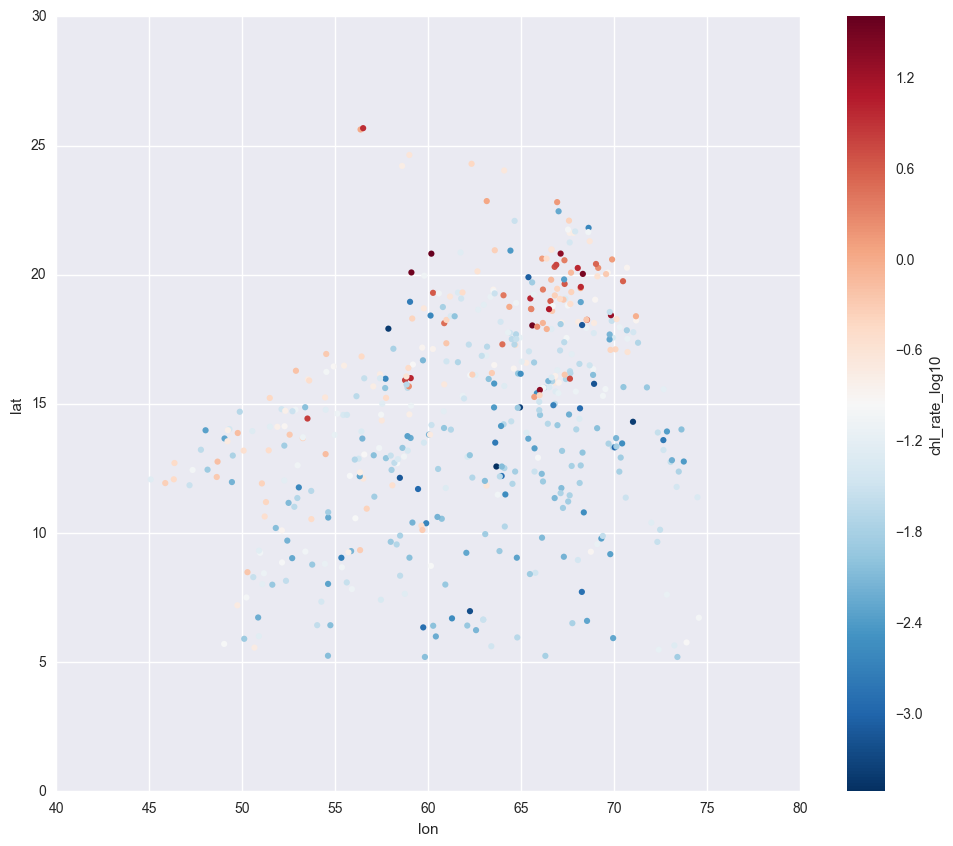

In [94]:
# prepare the data in dataset and about to take the diff
tmp = xr.Dataset.from_dataframe(floatsDFAll_4Dtimeorder.set_index(['time','id']) ) # set time & id as the index); use reset_index to revert this operation
# take the diff on the chlor_a
chlor_a_rate = tmp.diff(dim='time',n=1).chlor_a.to_series().reset_index()
# make the column to a proper name
chlor_a_rate.rename(columns={'chlor_a':'chl_rate'}, inplace='True')
chlor_a_rate


# merge the two dataframes {floatsDFAll_XDtimeorder; chlor_a_rate} into one dataframe based on the index {id, time} and use the left method
floatsDFAllRate_4Dtimeorder=pd.merge(floatsDFAll_4Dtimeorder,chlor_a_rate, on=['time','id'], how = 'left')
floatsDFAllRate_4Dtimeorder

# check 
print('check the sum of the chlor_a before the merge', chlor_a_rate.chl_rate.sum())
print('check the sum of the chlor_a after the merge',floatsDFAllRate_4Dtimeorder.chl_rate.sum())


# visualize the chlorophyll rate, it is *better* to visualize at this scale
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_4Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.8, vmax=0.8, edgecolor='none', ax=ax)

# visualize the chlorophyll rate on the log scale
floatsDFAllRate_4Dtimeorder['chl_rate_log10'] = floatsDFAllRate_4Dtimeorder['chl_rate'].apply(scale)
floatsDFAllRate_4Dtimeorder
fig, ax  = plt.subplots(figsize=(12,10))
floatsDFAllRate_4Dtimeorder.plot(kind='scatter', x='lon', y='lat', c='chl_rate_log10', cmap='RdBu_r', edgecolor='none', ax=ax)
#floatsDFAllRate_4Dtimeorder.chl_rate.dropna().shape   # (1099,) data points
floatsDFAllRate_4Dtimeorder.chl_rate_log10.dropna().shape   # (493,) data points..... notice, chl_rate can be negative, so do not take log10

In [95]:
pd.to_datetime(floatsDFAllRate_4Dtimeorder.time)
type(pd.to_datetime(floatsDFAllRate_4Dtimeorder.time))
ts = pd.Series(0, index=pd.to_datetime(floatsDFAllRate_4Dtimeorder.time) ) # creat a target time series for masking purpose

# take the month out
month = ts.index.month 
# month.shape # a check on the shape of the month.
selector = ((11==month) | (12==month) | (1==month) | (2==month) | (3==month) )  
selector
print('shape of the selector', selector.shape)

print('all the data count in [11-01, 03-31]  is', floatsDFAllRate_4Dtimeorder[selector].chl_rate.dropna().shape) # total (774,)
print('all the data count is', floatsDFAllRate_4Dtimeorder.chl_rate.dropna().shape )   # total (1099,)

shape of the selector (331002,)
all the data count in [11-01, 03-31]  is (774,)
all the data count is (1099,)


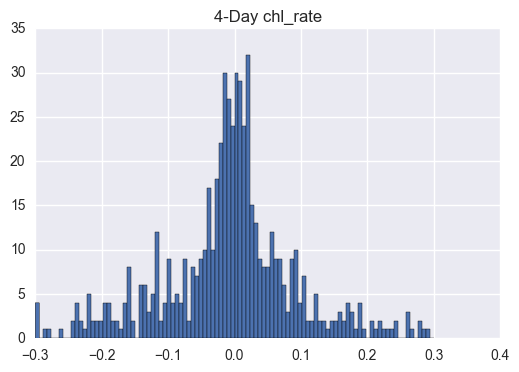

In [96]:
# histogram for non standarized data
axfloat = floatsDFAllRate_4Dtimeorder[selector].chl_rate.dropna().hist(bins=100,range=[-0.3,0.3])
axfloat.set_title('4-Day chl_rate')

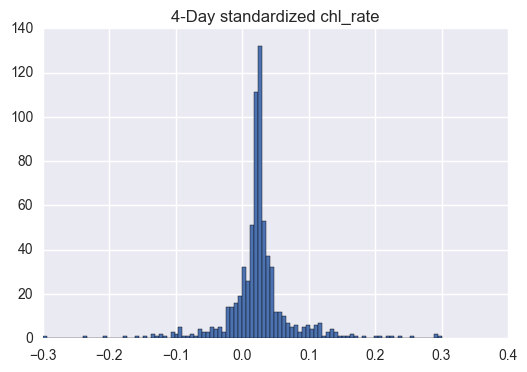

In [97]:
# standarized series
ts = floatsDFAllRate_4Dtimeorder[selector].chl_rate.dropna()
ts_standardized = (ts - ts.mean())/ts.std()
axts = ts_standardized.hist(bins=100,range=[-0.3,0.3])
axts.set_title('4-Day standardized chl_rate')

(49,)
(53,)
(5,)
(39,)
(89,)
(77,)
(144,)
(44,)
(62,)
(19,)
(40,)
(43,)
(251,)
(127,)
(51,)


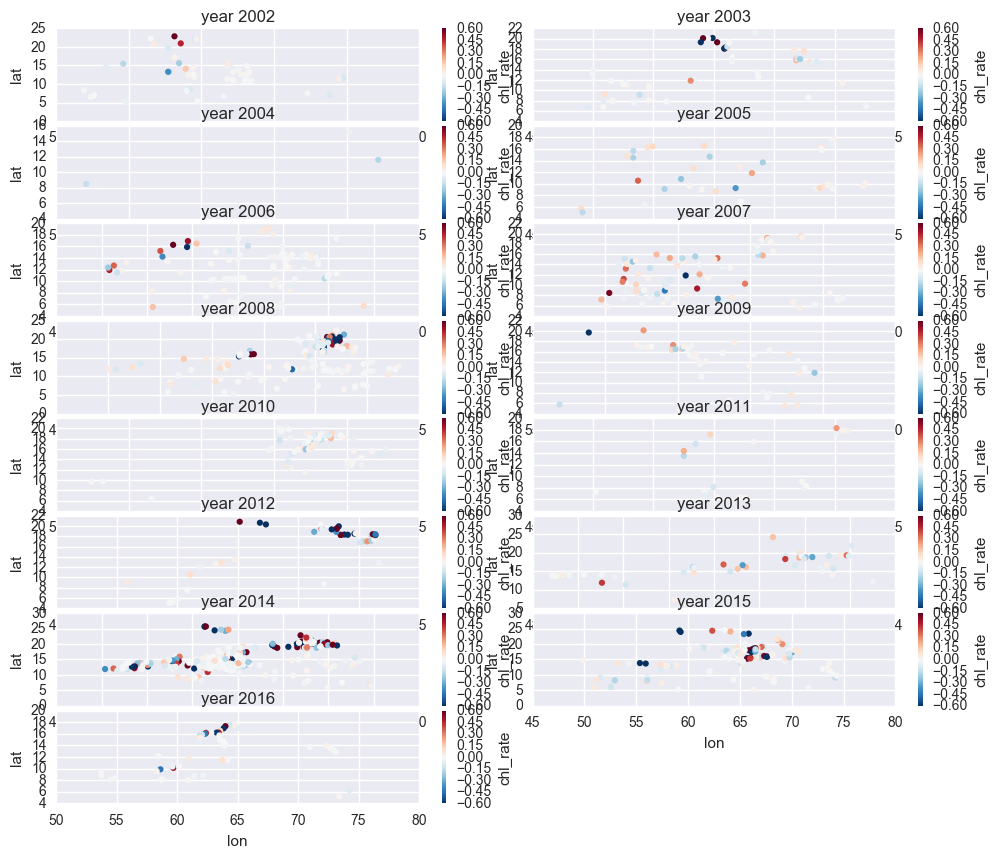

In [98]:
# all the data
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2017), axes.flat) :
    tmpyear = floatsDFAllRate_4Dtimeorder[ (floatsDFAllRate_4Dtimeorder.time > str(i))  & (floatsDFAllRate_4Dtimeorder.time < str(i+1)) ] # if year i
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)   # total is 1093
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r',vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)     
    
# remove the extra figure
ax = plt.subplot(8,2,16)
fig.delaxes(ax)

(66,)
(0,)
(9,)
(67,)
(30,)
(126,)
(36,)
(55,)
(1,)
(40,)
(0,)
(169,)
(118,)
(57,)


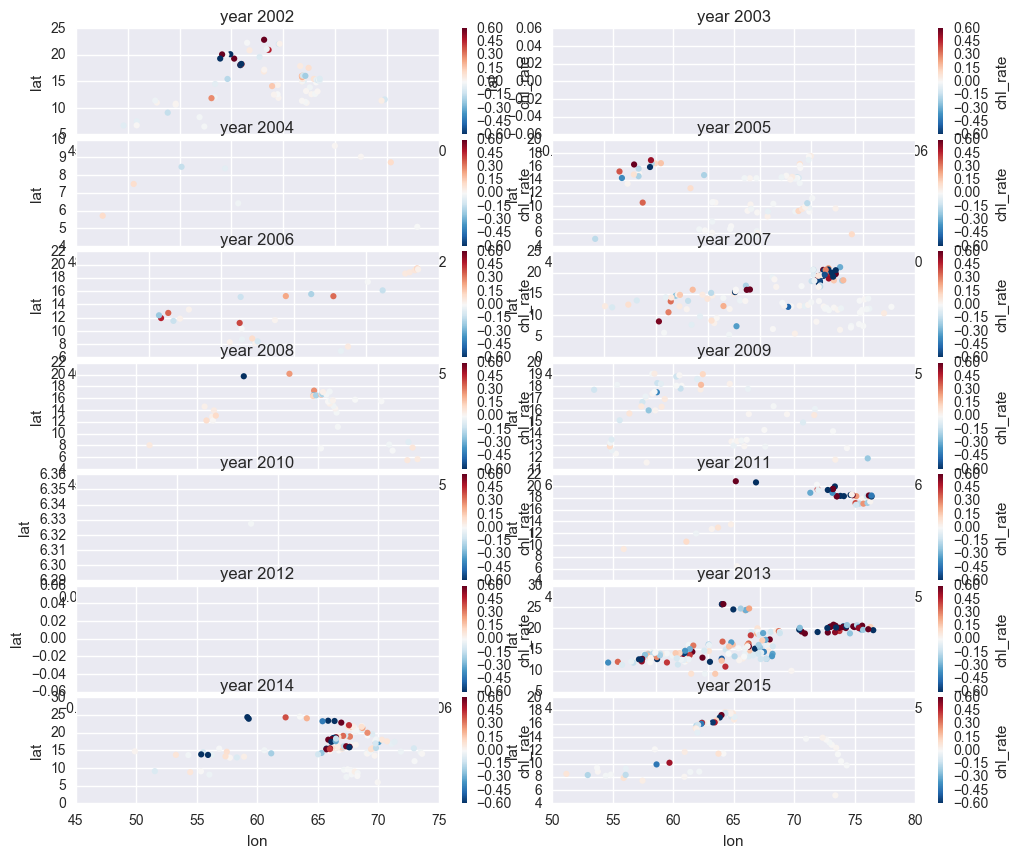

In [99]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, ax in zip(range(2002,2016), axes.flat) :
    tmpyear = floatsDFAllRate_4Dtimeorder[ (floatsDFAllRate_4Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_4Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    #fig, ax  = plt.subplots(figsize=(12,10))
    print(tmpyear.chl_rate.dropna().shape)  # the total is 774
    tmpyear.plot(kind='scatter', x='lon', y='lat', c='chl_rate', cmap='RdBu_r', vmin=-0.6, vmax=0.6, edgecolor='none', ax=ax)
    ax.set_title('year %g' % i)  

In [100]:
# let's output the data as a csv or hdf file to disk to save the experiment time

df_list = []
for i in range(2002,2017) :
    tmpyear = floatsDFAllRate_4Dtimeorder[ (floatsDFAllRate_4Dtimeorder.time >= (str(i)+ '-11-01') )  & (floatsDFAllRate_4Dtimeorder.time <= (str(i+1)+'-03-31') ) ] # if year i
    # select only particular month, Nov 1 to March 31
    df_list.append(tmpyear)
    
df_tmp = pd.concat(df_list)
print('all the data count in [11-01, 03-31]  is ', df_tmp.chl_rate.dropna().shape) # again, the total is  (774,)
df_chl_out_4D_modisa = df_tmp[~df_tmp.chl_rate.isnull()] # only keep the non-nan values
#list(df_chl_out_XD.groupby(['id']))   # can see the continuity pattern of the Lagarangian difference for each float id

# output to a csv or hdf file
df_chl_out_4D_modisa.head()

all the data count in [11-01, 03-31]  is  (774,)


,id,time,ve,vn,lat,spd,var_tmp,temp,var_lon,var_lat,lon,chlor_a,chlor_a_log10,chl_rate,chl_rate_log10
7793,34710,2002-11-01,1.633062,12.896375,16.864937,13.935000,0.001790,28.994687,0.000128,0.000066,63.124500,0.385674,-0.413780,0.060035,-1.221596
8030,10206,2002-11-05,-7.127375,6.176937,10.969438,11.645312,1000.000000,NaN,0.001244,0.000420,67.246562,0.142620,-0.845818,0.014256,-1.846018
8034,15707,2002-11-05,-19.271875,-17.786375,13.879687,26.887063,1000.000000,NaN,0.000134,0.000069,67.560500,0.154235,-0.811817,-0.025134,NaN
8052,34710,2002-11-05,-0.118437,10.472312,17.212188,10.930375,0.001605,28.945750,0.000118,0.000062,63.165562,0.407654,-0.389708,0.021980,-1.657972
8058,34721,2002-11-05,6.933938,-2.230437,12.594937,14.224375,0.001764,29.537625,0.000098,0.000054,67.715438,0.154256,-0.811758,0.015577,-1.807530


In [101]:
df_chl_out_4D_modisa.index.name = 'index'  # make it specific for the index name

# CSV CSV CSV CSV with specfic index
df_chl_out_4D_modisa.to_csv('df_chl_out_4D_modisa.csv', sep=',', index_label = 'index')

# load CSV output
test = pd.read_csv('df_chl_out_4D_modisa.csv', index_col='index')
test.head()

,id,time,ve,vn,lat,spd,var_tmp,temp,var_lon,var_lat,lon,chlor_a,chlor_a_log10,chl_rate,chl_rate_log10
index,,,,,,,,,,,,,,,
7793,34710,2002-11-01,1.633063,12.896375,16.864937,13.935000,0.001790,28.994688,0.000128,0.000066,63.124500,0.385674,-0.413780,0.060035,-1.221596
8030,10206,2002-11-05,-7.127375,6.176937,10.969438,11.645312,1000.000000,NaN,0.001244,0.000420,67.246562,0.142620,-0.845818,0.014256,-1.846018
8034,15707,2002-11-05,-19.271875,-17.786375,13.879687,26.887063,1000.000000,NaN,0.000134,0.000069,67.560500,0.154235,-0.811817,-0.025134,NaN
8052,34710,2002-11-05,-0.118437,10.472312,17.212188,10.930375,0.001605,28.945750,0.000118,0.000062,63.165562,0.407654,-0.389708,0.021980,-1.657972
8058,34721,2002-11-05,6.933938,-2.230437,12.594938,14.224375,0.001764,29.537625,0.000098,0.000054,67.715438,0.154256,-0.811758,0.015577,-1.807530
